### Advanced Machine Learning

# Final Assignment  - Detect True vs False Stories (lie detection)

Assignment Start: 11/07/21 00:00<br>
Assignment Due: 18/07/21 23:59 (moodle will be closed for submissions that time)

Jonathan Schler


In [36]:
id="337839112"
name="Sofya Zubtsovsky"

## Introduction
You are provided with a labeled corpus of narratives in Hebrew. The corpus is provided as a csv file. Each row represents a narrative. It has 5 fields: id, author_gender, author_birth_year, narrative and label. The label for each narrative indicates whether this is a true or false story (i.e. the author lied when he told the story) (label "1" for True, and "0" for false). 

You are requested to build a model to predict whether a new story in Hebrew is true or false (i.e a lie). You are provided with 2 files: 
- `train_dataset.csv` - which contains **labeled** examples, and 
- `test_dataset.csv` that contains **unlabled** examples that you'll have to classify and submit the results. The narrtives in this file will have the same fields except of the label field.

(you'll be graded based on the quality of the labels assigned to the `test_dataset.csv`).





## What is expected from you
1. Build a classifier (including all pre-processing steps - as you think may fit (feature engineering, pre-processing, scaling etc) ) that will classify an unlabled document (including reasonable documentation for the steps you chose to do)
2. Report on how you chose to evaluate your algorithm and the scores of that evaluation
3. Apply the model on the unlabeled data set (`test_dataset.csv`), and return the results in the format described below
4. At the end, you are requested to submit 2 files: (a) this notebook, and (b) the output csv file. Submission will be done via moodle. The output csv is the file, that contains the prediction for the `test_dataset.csv`. The naming of the file should be `<your_id_number>.csv` (where `<your_id_number>` will be replaced with you actual ID number). The file will contain for each doc a label `1` (for true narratives) or `0` (for false narratives) (such that each row contains only one label, corresponding to the document in the given row in the `test_dataset.csv` document). You can see a sample output file under the name `123456789.csv` in the moodle.

## Grading Guidelines
1. Overall approach and workable solution (70 pts)
2. Average f1 score of higher than 0.50 (10 pts)
3. Average f1 score of higher than 0.58 (additional 5 pts)
4. Competitive element: 15 Highest average f1 score - will get additional 15 pts, top score the extra 15 points, second highest - extra 14 points etc - in case of similar scores it will be divided proportionaly.

## Other Guidelines
1. Work in indivudual, collaboration is not allowed. 
2. You are allowed to use all the toolsets we learned / mentioned in class, in addition to any other avialble toolsets for text processing or Hebrew data as you think is appropriate.


## Good Luck!

In [37]:
pip install python-bidi #worked for me

You should consider upgrading via the '/home/zsofya/jupyter_git/jup-nb-generic/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
pd.options.display.float_format = '{:f}'.format
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from bidi import algorithm as bidialg      # needed for arabic, hebrew


In [39]:
# utilities function are same as were implemented
# with Alexander Kruglyak for assigments during the semester

def show_data_basic_information(df):
    print("Info\n")
    print(df.info())
    print("\n" + "*" * 10 + "\n")
    
    print("Shape\n")
    print(df.shape) 
    print("\n" + "*" * 10 + "\n")
    
    print("Amount of is null data\n")
    print(df.isnull().sum().max())
    print("\n" + "*" * 10 + "\n")
    
    print("Describe\n")
    display(df.describe())
    print("\n" + "*" * 10 + "\n")
    
def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)

def get_label_and_drop(_df):
    df = _df.copy()
    label = df['label']
    df = drop_columns(df,['label'])
    return df, label

def show_random_text(_df,feature,n=1):
    df = _df.sample(n=n,random_state=42)
    print(list(df[feature]))
    
def get_cross_val_score(scores_df,estimator,X_train,y_train,prefix="",sampler=None):
        name = estimator.__class__.__name__
        pipe = estimator
        sampler_name = ""
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        full_scores = cross_validate(
            pipe,
            X_train, 
            y_train, 
            cv=10,
            scoring=('roc_auc', 'average_precision', 'recall', 'f1'),
            n_jobs = -1
        )
        add_score(scores_df, full_scores, estimator.__class__.__name__,prefix)
        
def add_score(scores_df, scores, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'f1'] = scores['test_f1'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'roc_auc'] = scores['test_roc_auc'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'recall'] = scores['test_recall'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'average_precision'] = scores['test_average_precision'].mean()
    
def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])

In [40]:
df_steps = {}

In [41]:
df_steps['0_full_df'] = pd.read_csv("train_dataset.csv")

In [42]:
df_test = pd.read_csv("test_dataset.csv")

## Step 1 - get familiar with the data

In [43]:
show_data_basic_information(df_steps['0_full_df'])

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         408 non-null    int64 
 1   author_gender      408 non-null    object
 2   author_birth_year  408 non-null    int64 
 3   narrative          408 non-null    object
 4   label              408 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 16.1+ KB
None

**********

Shape

(408, 5)

**********

Amount of is null data

0

**********

Describe



,Unnamed: 0,author_birth_year,label
count,408.000000,408.000000,408.000000
mean,203.500000,1993.573529,0.500000
std,117.923704,3.370560,0.500614
min,0.000000,1980.000000,0.000000
25%,101.750000,1992.750000,0.000000
50%,203.500000,1994.000000,0.500000
75%,305.250000,1995.000000,1.000000
max,407.000000,2002.000000,1.000000



**********



In [44]:
show_data_basic_information(df_test)

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         106 non-null    int64 
 1   author_gender      106 non-null    object
 2   author_birth_year  106 non-null    int64 
 3   narrative          106 non-null    object
dtypes: int64(2), object(2)
memory usage: 3.4+ KB
None

**********

Shape

(106, 4)

**********

Amount of is null data

0

**********

Describe



,Unnamed: 0,author_birth_year
count,106.000000,106.000000
mean,52.500000,1993.905660
std,30.743563,2.755180
min,0.000000,1984.000000
25%,26.250000,1993.000000
50%,52.500000,1994.000000
75%,78.750000,1995.000000
max,105.000000,2002.000000



**********



In [45]:
df_steps['0_full_df']

,Unnamed: 0,author_gender,author_birth_year,narrative,label
0,0,זכר,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1
1,1,זכר,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1
2,2,זכר,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1
3,3,נקבה,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1
4,4,נקבה,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1
...,...,...,...,...,...
403,403,זכר,1988,"ללמוד להעז יותר, אחד החוויה הזאת שעשיתי באה אח...",0
404,404,זכר,1993,זה קרה לפניי מספר שבועות עוד כשהיינו תחת סגרים...,0
405,405,זכר,1995,"לפני שלוש שנים, לאחר שחסכתי, טסתי עם חבר מאוד ...",0
406,406,נקבה,1993,כשהייתי ילדה קטנה בבית הספר בגיל 8 הייי ילדה מ...,0


In [46]:
df_test

,Unnamed: 0,author_gender,author_birth_year,narrative
0,0,זכר,2002,זה התחיל בשעת השקיעה.הגענו לחוף מדרום לעין גדי...
1,1,נקבה,1995,"כזוג מאורס טרי סגרנו תאריך, אולם אירועים, ספקי..."
2,2,זכר,1995,"הגעתי לשירות המדינה אחרי שנתיים כפעיל בתנועת ""..."
3,3,זכר,1991,"בשנה האחרונה ,\nפרצה מחלת הקורונה דבר שאף אחד ..."
4,4,זכר,1995,"החוויה שלי מתחילה במכון הטכנולוגי חולון, אשר ש..."
...,...,...,...,...
101,101,זכר,1995,"לפני שנה החלטתי שאני רוצה להיות טייס, התחלתי ל..."
102,102,זכר,1994,"לכבוד יום ההולדת שלי, בת הזוג שלי החליטה להפתי..."
103,103,זכר,1995,בשנת 2020 בחודש מרץ הייתי אמור להתחתן עם אחת ש...
104,104,זכר,1991,לפני שבועיים הלכתי לספארי יצאנו בשעה 12 בצהריי...


## Initial processing:
- drop 'Unnamed 0' column
- encode author_gender
- add feature - length of the narrative
- (?) - replace birth year with age

In [47]:
def encode_gender(_df):
    df = _df.copy()
    man = "זכר"
    woman = "נקבה"
    gender = {man: 0, woman: 1}
    df['author_gender'] = [gender[item] for item in df['author_gender']]
    return df

In [48]:
def add_length_of_narrative(_df):
    df = _df.copy()
    df['nar_length'] = df['narrative'].str.len()
    return df

In [52]:
def clean_end_of_line(_df):
    df = _df.copy()
    df['narrative'] =df['narrative'].str.replace(r'\n', '')
    return df

In [53]:
df_steps['1_dropped'] = drop_columns(df_steps['0_full_df'],['Unnamed: 0'])
df_steps['2_gender'] = encode_gender(df_steps['1_dropped'])
df_steps['3_nar_length'] = add_length_of_narrative(df_steps['2_gender'])
df_steps['3_nar_length']

,author_gender,author_birth_year,narrative,label,nar_length
0,0,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1,1748
1,0,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1,1696
2,0,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1,1967
3,1,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1,1648
4,1,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1,1553
...,...,...,...,...,...
403,0,1988,"ללמוד להעז יותר, אחד החוויה הזאת שעשיתי באה אח...",0,2561
404,0,1993,זה קרה לפניי מספר שבועות עוד כשהיינו תחת סגרים...,0,1670
405,0,1995,"לפני שלוש שנים, לאחר שחסכתי, טסתי עם חבר מאוד ...",0,2032
406,1,1993,כשהייתי ילדה קטנה בבית הספר בגיל 8 הייי ילדה מ...,0,1457


- Plot see the distribution of the data

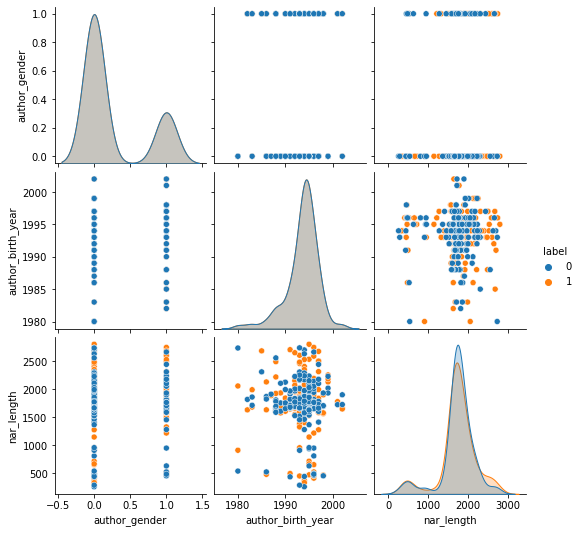

In [54]:
sns.pairplot(df_steps['3_nar_length'], hue='label')

In [55]:
df_test = drop_columns(df_test,['Unnamed: 0'])
df_test = encode_gender(df_test)
df_test= add_length_of_narrative(df_test)

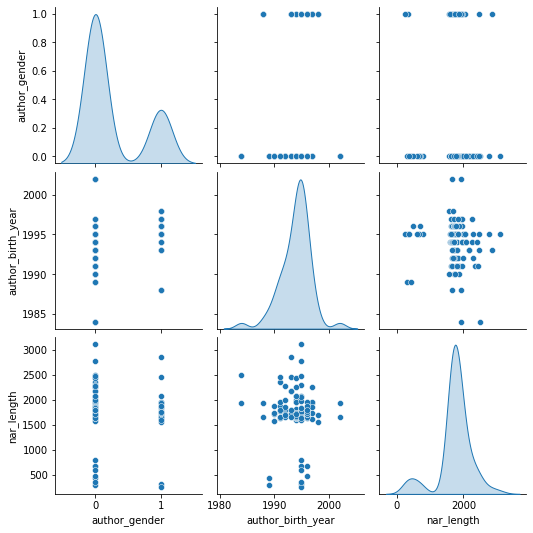

In [56]:
sns.pairplot(df_test, diag_kind='kde')

Text(0.5, 1.0, 'Train: narrative\n (0: False || 1: True)')

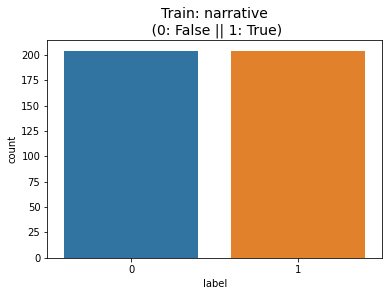

In [57]:
sns.countplot(x='label',data=df_steps['3_nar_length'])
plt.title('Train: narrative\n (0: False || 1: True)', fontsize=14)

Text(0.5, 1.0, 'Train: Gender \n (0: Male || 1: Female)')

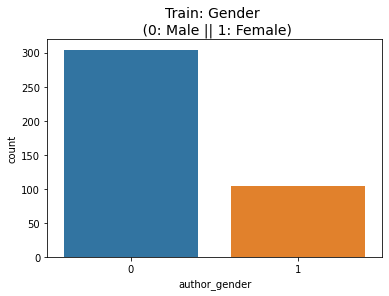

In [58]:
sns.countplot(x='author_gender',data=df_steps['3_nar_length'])
plt.title('Train: Gender \n (0: Male || 1: Female)', fontsize=14)

Text(0.5, 1.0, 'Test: Gender \n (0: Male || 1: Female)')

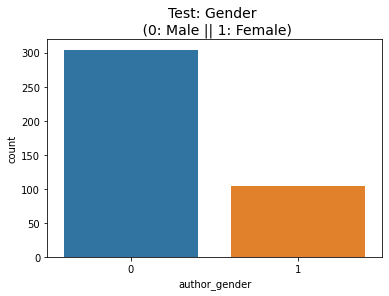

In [59]:
sns.countplot(x='author_gender',data=df_steps['3_nar_length'])
plt.title('Test: Gender \n (0: Male || 1: Female)', fontsize=14)

## Conclustion from step 1
- data is balanced
- there is no significant differences between features distribution per label
- narrative has to be cleaned from \n

In [60]:
df_steps['4_clean_nar'] = clean_end_of_line(df_steps['3_nar_length'])

<ipython-input-52-b33e9035b805>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['narrative'] =df['narrative'].str.replace(r'\n', '')


## Step 2 - tokenize the narrative

### Load stop words

In [62]:
stop_words = [x.strip() for x in open('heb_stopwords.txt','r').read().split('\n')]

In [63]:
text_train = df_steps['4_clean_nar']['narrative'].tolist()
text_test = df_test['narrative'].tolist()
y_train = df_steps['4_clean_nar']['label']

In [64]:
print (len(text_train))
print (len(y_train))

408
408


In [65]:
vect = CountVectorizer(min_df=4,stop_words=stop_words)
X_train = vect.fit_transform(text_train)
print(X_train.shape)

(408, 3931)


In [66]:
def sample_features(features):
    n = len(features)
    print(feature_names[:20])
    print(feature_names[round(n/2)-10:round(n/2)+10])
    print(feature_names[::round(n/10)])

In [67]:
#Vocabulary
feature_names = vect.get_feature_names()
sample_features(feature_names)

['00', '000', '10', '100', '1000', '11', '12', '13', '14', '15', '16', '18', '20', '200', '2020', '2021', '21', '22', '23', '24']
['ירדנו', 'ירדתי', 'ירוק', 'ירצה', 'ירקות', 'ישב', 'ישבו', 'ישבנו', 'ישבתי', 'ישירות', 'ישמע', 'ישן', 'ישנה', 'ישנו', 'ישנים', 'ישנם', 'ישנתי', 'ישר', 'ישראלים', 'ישראלית']
['00', 'במספר', 'ההרגשה', 'הצניחה', 'ולמצוא', 'ישירות', 'למטוס', 'מטלטלת', 'סדר', 'שאמרו', 'תשע']


In [68]:
print (len(feature_names))

3931


In [69]:
def train_and_predict(estimator,X_train,y_train,X_test):
    model = estimator.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return model,y_pred

In [70]:
regressors = [
    LogisticRegression(),
    LogisticRegressionCV(),
    PassiveAggressiveClassifier(),
    Perceptron(),
    RidgeClassifier(),
    RidgeClassifierCV(),
    SGDClassifier()
]
scores_df = pd.DataFrame(dtype=float)

In [71]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"count_vectorizer")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [72]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
PassiveAggressiveClassifier_count_vectorizer,0.546278,0.576738,0.549048,0.610693
LogisticRegressionCV_count_vectorizer,0.547085,0.620762,0.540000,0.628137
LogisticRegression_count_vectorizer,0.548916,0.587702,0.554048,0.615188
SGDClassifier_count_vectorizer,0.552084,0.578179,0.554286,0.601290
RidgeClassifier_count_vectorizer,0.552907,0.567810,0.559286,0.604054


In [73]:
#TfidfVectorizer
tdif = TfidfVectorizer(min_df=4,stop_words=stop_words)
X_train = tdif.fit_transform(text_train)
X_train = normalize(X_train,norm="l1")

In [74]:
print (len(text_train))
len(tdif.get_feature_names())

408


3931

In [75]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"Tfid_norm")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [76]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
RidgeClassifier_count_vectorizer,0.552907,0.567810,0.559286,0.604054
LogisticRegressionCV_Tfid_norm,0.554672,0.604595,0.559048,0.620404
RidgeClassifierCV_Tfid_norm,0.569085,0.617119,0.578333,0.634616
Perceptron_Tfid_norm,0.576685,0.585607,0.583095,0.620991
SGDClassifier_Tfid_norm,0.630866,0.620560,0.762143,0.639892


In [77]:
# L1 normalization with CountVectorizer
count_vec = CountVectorizer(min_df=4,stop_words=stop_words)
X_train = count_vec.fit_transform(text_train)
X_train = normalize(X_train,norm="l1")

In [78]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"CountVectorizer_norm")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [79]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
Perceptron_CountVectorizer_norm,0.583113,0.570869,0.627857,0.591285
RidgeClassifierCV_CountVectorizer_norm,0.590940,0.620905,0.602619,0.640249
LogisticRegressionCV_CountVectorizer_norm,0.593541,0.617690,0.597857,0.641610
SGDClassifier_CountVectorizer_norm,0.619578,0.624333,0.692381,0.639525
SGDClassifier_Tfid_norm,0.630866,0.620560,0.762143,0.639892


In [80]:
#ngrams
ngrm = CountVectorizer(ngram_range=(1, 3), min_df=4,stop_words=stop_words)
X_train = ngrm.fit_transform(text_train)
X_train = normalize(X_train,norm="l1")

In [83]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"CountV_ngrm_norm")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [84]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
Perceptron_CountVectorizer_norm,0.583113,0.570869,0.627857,0.591285
RidgeClassifierCV_CountVectorizer_norm,0.590940,0.620905,0.602619,0.640249
LogisticRegressionCV_CountVectorizer_norm,0.593541,0.617690,0.597857,0.641610
SGDClassifier_CountVectorizer_norm,0.619578,0.624333,0.692381,0.639525
SGDClassifier_Tfid_norm,0.630866,0.620560,0.762143,0.639892


In [85]:
cv = CountVectorizer(ngram_range=(1, 3), analyzer="char_wb",stop_words=stop_words)
X_train = cv.fit_transform(text_train)
X_train = normalize(X_train,norm="l1")
print(f"vocaulary size:{len(cv.vocabulary_)}")

vocaulary size:13253


In [86]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"CountV_char_wb_norm")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [118]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
Perceptron_CountVectorizer_norm,0.583113,0.570869,0.627857,0.591285
RidgeClassifierCV_CountVectorizer_norm,0.590940,0.620905,0.602619,0.640249
LogisticRegressionCV_CountVectorizer_norm,0.593541,0.617690,0.597857,0.641610
SGDClassifier_CountVectorizer_norm,0.619578,0.624333,0.692381,0.639525
SGDClassifier_Tfid_norm,0.630866,0.620560,0.762143,0.639892


### Get an impression of data by looking at most important features

In [100]:
tdif = TfidfVectorizer(stop_words=stop_words,min_df=4)
X_train = tdif.fit_transform(text_train)
X_train = normalize(X_train,norm="l1")
sgc = SGDClassifier()
sgc.fit(X_train, y_train)

SGDClassifier()

In [101]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    heb_feature_names =[bidialg.get_display(feature) for feature in feature_names[important]]
    ax.set_xticklabels(heb_feature_names, rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

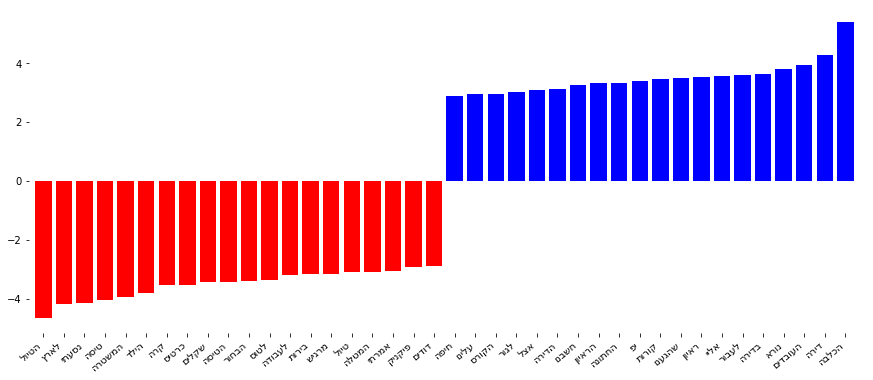

In [102]:
plt.figure(figsize=(15, 6))
plot_important_features(sgc.coef_.ravel(), np.array(tdif.get_feature_names()), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

In [103]:
pip install hebrew_tokenizer

You should consider upgrading via the '/home/zsofya/jupyter_git/jup-nb-generic/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Feature engineering

 ### - Add feature 'mention of specific time in narrative'

In [104]:
import hebrew_tokenizer as ht
hebrew_text = text_train
heb_vec=CountVectorizer().fit(hebrew_text)
heb_vec.get_feature_names() 
sample_features(feature_names)

['00', '000', '10', '100', '1000', '11', '12', '13', '14', '15', '16', '18', '20', '200', '2020', '2021', '21', '22', '23', '24']
['ירדנו', 'ירדתי', 'ירוק', 'ירצה', 'ירקות', 'ישב', 'ישבו', 'ישבנו', 'ישבתי', 'ישירות', 'ישמע', 'ישן', 'ישנה', 'ישנו', 'ישנים', 'ישנם', 'ישנתי', 'ישר', 'ישראלים', 'ישראלית']
['00', 'במספר', 'ההרגשה', 'הצניחה', 'ולמצוא', 'ישירות', 'למטוס', 'מטלטלת', 'סדר', 'שאמרו', 'תשע']


In [105]:
time_column = []
for text in hebrew_text:
    text_grp = []
    tokens = ht.tokenize(text)  # tokenize returns a generator!
    for grp, token, token_num, (start_index, end_index) in tokens:
        text_grp.append(grp)
    cnt_time = text_grp.count('HOUR') + text_grp.count('DATE') + text_grp.count('DATE_1') + text_grp.count('DATE_2')
    time_column.append(cnt_time)
df_steps['5_time_count'] = df_steps['4_clean_nar']
df_steps['5_time_count']['cnt_time']=time_column
display(df_steps['5_time_count'].sort_values(by='cnt_time').tail(10))  
df_steps['5_time_count']['cnt_time'].value_counts()

,author_gender,author_birth_year,narrative,label,nar_length,cnt_time
390,1,1997,"בחודש יולי האחרון, נסעתי עם משפחתי המורחבת מצד...",0,2180,2
137,0,1993,"אחד מימי החול באמצע השבוע, מנהג של שנים עוד מג...",1,2027,2
136,0,1990,לפני חודש וחצי קמתי בבוקר עם כאבים חזקים מאוד....,1,1664,2
221,0,1997,במהלך שלושת החודשים האחרונים עוברת עלי תקופה ל...,0,1416,2
132,0,1996,חוויה שהייתה לי בשנה האחרונה התחילה בכך שהתקבל...,1,1900,2
379,0,1993,בתאריך ה 11.01.21 טסתי עם בת הזוג שלי לפולין ל...,0,1831,2
335,0,1999,בסמסטר קודם אני וכמה חברים ללימודים קבענו להיפ...,0,1935,2
169,0,1994,ביום חמישי הבן שלי ועוד מספר חברים הזמינו פיצה...,1,1624,3
196,0,1992,"מהלך חודש דצמבר, מזג האוויר מקסים ולא אופייני ...",1,1956,3
174,0,1994,"זהו היה יום חמישי אחר הצהריים, היום בו נקבע לי...",1,1779,6


0    387
1     11
2      7
3      2
6      1
Name: cnt_time, dtype: int64

 ### - Add feature 'topic of narrative'

In [106]:
from sklearn.decomposition import LatentDirichletAllocation
lda10 = LatentDirichletAllocation(n_components=20, learning_method="batch")
X_lda10 = lda10.fit_transform(X_train)

In [107]:
def plot_important_features2(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    heb_feature_names =[bidialg.get_display(feature) for feature in feature_names[combined_inds]]
    ax.set_xticklabels(heb_feature_names, rotation=60, ha="right")

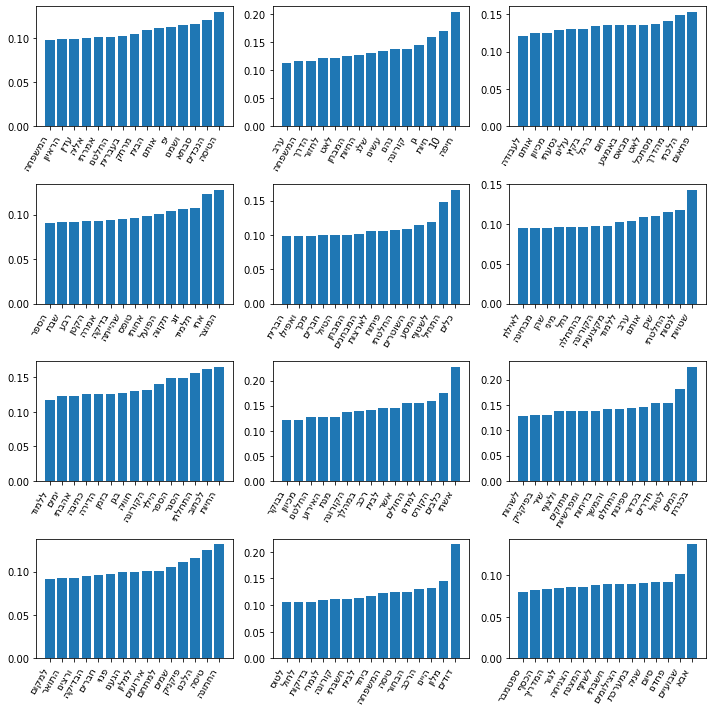

In [108]:
feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lda10.components_):
    plot_important_features2(coef, feature_names, top_n=15, ax=ax)
    
plt.tight_layout()

In [109]:
def print_topics(topics, feature_names, components, topics_per_chunk=6,
                 n_words=20):
    #sorting = np.argsort(components, axis=1)[:, ::-1]
    sorting= components
    
    
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for ii in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, ii]]))
            except:
                pass
        print("\n")


In [110]:
sorting = np.argsort(lda10.components_, axis=1)[:, ::-1]
print_topics(np.argsort(X_lda10.sum(axis=0))[::-1][:30], feature_names, sorting, topics_per_chunk=8)

topic 13      topic 6       topic 7       topic 12      topic 2       topic 19      topic 10      topic 18      
--------      --------      --------      --------      --------      --------      --------      --------      
בסדר          החיות         אשתי          הספר          פתאום         הרכב          דודים         הכלבה         
העבודה        לכתוב         כלבים         כלב           הלכתי         רכב           מלון          בירות         
התחלתי        התחלתי        הקורס         לבית          מהדרך         הבחור         היינו         בירה          
חברה          הסגר          למדנו         לשחות         מסתכל         ליד           הרכב          תל            
לעבוד         הספר          החולים        חברים         לאט           התחיל         הבחור         לעבוד         
בשנה          הילד          אשר           הילד          מבאס          לצאת          טיסה          לארץ          
הדירה         הקורונה       לבית          קרוב          באמצע         המזוודה       המשפחה      

In [111]:
topic = []
for i in range(len(text_train)):
    topic.append(np.argmax(X_lda10[i]))
df_steps['6_topic']=df_steps['5_time_count']
df_steps['6_topic']['topic']=topic

In [112]:
df_steps['6_topic']['topic'].value_counts()

13    35
6     31
7     29
12    27
2     26
10    23
19    23
18    20
5     19
8     19
1     19
14    19
16    19
4     18
9     16
0     16
17    15
3     13
15    12
11     9
Name: topic, dtype: int64

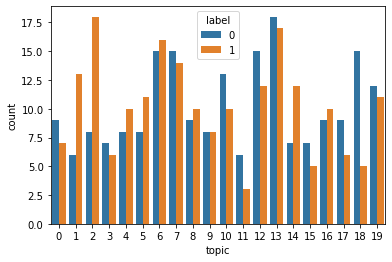

In [113]:
ax = sns.countplot(x="topic", hue="label", data=df_steps['6_topic'])

## Conclision: 
we can see a diffetence in topic selection between truth / fake stories.

## Combine text and numerical features

In [114]:
df_steps['6_topic']

,author_gender,author_birth_year,narrative,label,nar_length,cnt_time,topic
0,0,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1,1748,0,14
1,0,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1,1696,0,5
2,0,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1,1967,0,16
3,1,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1,1648,0,13
4,1,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1,1553,0,2
...,...,...,...,...,...,...,...
403,0,1988,"ללמוד להעז יותר, אחד החוויה הזאת שעשיתי באה אח...",0,2561,0,13
404,0,1993,זה קרה לפניי מספר שבועות עוד כשהיינו תחת סגרים...,0,1670,0,6
405,0,1995,"לפני שלוש שנים, לאחר שחסכתי, טסתי עם חבר מאוד ...",0,2032,0,8
406,1,1993,כשהייתי ילדה קטנה בבית הספר בגיל 8 הייי ילדה מ...,0,1457,0,12


In [116]:
X_train,y_tain = get_label_and_drop(df_steps['6_topic'])

In [117]:
def get_num_text_pipeline(df,regr_num,regr_text):
    numeric_cols = df.columns[df.columns.dtype != object].tolist()
    
    transformer_text = FunctionTransformer(lambda x: x['narrative'], validate=False)
    transfomer_numeric = FunctionTransformer(lambda x: x[numeric_cols], validate=False)

    pipeline = Pipeline([
        ('features', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', transfomer_numeric)
                ])),
                 ('text_features', Pipeline([
                    ('selector', transformer_text),
                    (regr_text.__class__.__name__, regr_text)
                ]))
             ])),
        ('estimator', regr_num)
    ])
    return pipeline

In [119]:
# selec a best tool for text 
regr_text = TfidfVectorizer(min_df=4,stop_words=stop_words,norm='l1')

In [121]:
for regr in regressors:
    pipe = get_num_text_pipeline(X_train,regr,regr_text)
    get_cross_val_score(scores_df,pipe, X_train, y_train,regr.__class__.__name__+"_combined")

*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********


In [122]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
RidgeClassifierCV_CountVectorizer_norm,0.590940,0.620905,0.602619,0.640249
LogisticRegressionCV_CountVectorizer_norm,0.593541,0.617690,0.597857,0.641610
SGDClassifier_CountVectorizer_norm,0.619578,0.624333,0.692381,0.639525
Pipeline_SGDClassifier_combined,0.623759,0.627571,0.742381,0.643189
SGDClassifier_Tfid_norm,0.630866,0.620560,0.762143,0.639892


meantime combined featues haven't improved the results so far...

## Translation

In [22]:
from transformers import MarianMTModel, MarianTokenizer

In [23]:
text_train = df_steps['4_clean_nar']['narrative'].tolist()

In [24]:
text_train[0]

'שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה מאוד חוויות בה, בין אם הן חיוביות או לעומת זאת שליליות, חלקן היו בעלות אופי דו משמעי, כלומר לעיתים חיובי ולחילופין שלילי. אחת החוויות היותר משפיעות הייתה מעבר מוסד לימודים, אפשר לסייג אותה בתור חוויה חיובית באופן כללי אך כמו שספרתי קודם לכן היו בה רגעים פחות חיוביים ואפילו שליליים למדי.זה היה למעשה מעבר מאוניברסיטה נחשבת מאוד למכללה מקצועית לא פחות אך עם שם איך נאמר פחות מפורסם ופחות יוצא מן השורות הראשונות של הקידמה האדמית בארץ ובכלל בעולם.המעבר הזה הכה חזק באגו ואף נגע בתדמית שלי, אפשר להגיד את זה בצורה ישירה ובדוקה שזו גם דעת הכלל על הפן המקצועי שלי.אני סובר שהחלק שהיה הכי משמעותי במכה הזאת הוא הציונים בקורסים השונים, כנראה שזה קרה כך כי מאחורי הקלעים אני הייתי מצפה להעלות את הציונים עקב הירידה בקושי האקדמי המשתמע מן השינוי אך זה לא קרה, שאלתי את עצמי מדוע זה כך פעמים רבות וטרם הבנתי את התשובה לכך.הלימודים במוסד החדש היו במתכונת רחוקה בלבד, למדתי שעות ורבות ואכן השקעתי את רוב כוחותיי במשימות והאתגרים, טוב, אם להיות כנה עד הסוף, לאחר חשי

In [25]:
src_text = text_train[0]

model_name = 'tiedeman/opus-mt-he-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
print(tokenizer.supported_language_codes)

model = MarianMTModel.from_pretrained(model_name)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True,truncation=True,max_length=512))
[tokenizer.decode(t, skip_special_tokens=True) for t in translated]

[]


["For me, I've been through a lot of experiences in which, whether it's positive or negative, some of them were of a two-way nature, that at times positive and negative."]

In [26]:
tokenizer

PreTrainedTokenizer(name_or_path='tiedeman/opus-mt-he-en', vocab_size=62955, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

In [32]:
en_column = []
for text in text_train:
    translated = model.generate(**tokenizer(text, return_tensors="pt", padding=True,truncation=True))
    en_text = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
    en_column.append(en_text)

KeyboardInterrupt: 

In [30]:
df_steps['4_clean_nar']['en_narrative'] = en_column

[["For me, I've been through a lot of experiences in which, whether it's positive or negative, some of them were of a two-way nature, that at times positive and negative."],
 ["Unlike most students, I have not decided to study to find a job later but to enrich myself and develop new worlds in technology because when I started studying, I've already worked in the tech industry for several years. Today after three years I can say that the academic system is still stuck behind and let me down very much. 80% of the degree doesn't even touch industry and 20% is far away from being helped."],
 ["A few years ago, my partner and I flew to London and it was at the end of December and we were supposed to celebrate there at the beginning of the new year, we flew to 10 days and prepared our Luz in advance so that we wouldn't waste time searching and planning for the last minute and then we would spend the last two days singing free time so that we could do what was right for us at the moment."],
 

In [35]:
df = pd.DataFrame(en_column)  
df.to_csv('en_narrative.csv') 

In [34]:
len(en_column)

369